In [1]:
# Imports
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats
from scipy import integrate
import statsmodels.discrete.discrete_model as sm
# from matplotlib.offsetbox import AnchoredText
# from sklearn.mixture import GaussianMixture

%config InlineBackend.figure_format = 'svg'

In [2]:
# Choose technology here
TECH = 'C'

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

In [3]:
colnames = ["addr", "time", "r", "g"]
data = pd.read_csv(f"data/tech{TECH}/techA_35hr.tsv", names=colnames, sep='\t')

data.head()
data.tail()

,addr,time,r,g
89605995,5738,167773.723675,25204.602794,0.00004
89605996,5738,167819.988000,24910.296175,0.00004
89605997,5738,167870.281253,25212.359966,0.00004
89605998,5738,167917.084308,24930.006086,0.00004
89605999,5738,167965.777883,25310.511030,0.00004


In [5]:
data["time"] -= data.groupby("addr")["time"].transform("first") 
data["gi"] = data.groupby("addr")["g"].transform("first")
data["range"] = np.int32(data["gi"] / settings["gmax"] * 32)

In [ ]:
# r = 16

# def count(gvals):
#     th = 1e-5 / 16 * r
#     diff = gvals.drop_duplicates(subset=['time']).sort_values(["time"]).diff()[1:]
#     event = diff["g"].div(diff["time"])
#     result = (abs(event) > th).value_counts().loc[True]
#     test = event[abs(event) > th]
#     # if count.counter == 0:
#     #     fig, ax = plt.subplots(1, 1, figsize=(6, 4))
#     #     ax.hist(event.values, density=True, bins=50)
#     #     ax.set_title(f"dg/dt Histogram Example\n(Tech {TECH}, Room Temp, Range 16)")
#     #     ax.set_ylabel("Frequency")
#     #     ax.set_xlabel("dg/dt")
#     #     plt.savefig("dg-histogram.svg", bbox_inches="tight")
#     #     plt.show()
#     #     count.counter += 1
#     return [result, abs(test).mean()]

# # count.counter = 0

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# cnt = data[data["range"]==r].groupby("addr")[["g", "time"]].apply(count)
# cnt = np.array([np.array(xi) for xi in cnt])
# hist = cnt[:, 0]
# intensity = cnt[:, 1]
# ax.hist(hist, density=True, bins=50)

# X = np.arange(0, 4000)
# ax.plot(X, scipy.stats.poisson.pmf(X, hist.mean()), 'r-')

# ax.set_title(f"Event count histogram\n(Tech {TECH}, Room Temp, Range 16)")
# ax.set_ylabel("Frequency")
# ax.set_xlabel("Event numbers")
# plt.savefig("event-histogram.svg", bbox_inches="tight")
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.set_title(f"Event intensity vs. Event count\n(Tech {TECH}, Room Temp, Range 16)")
# ax.set_ylabel("Mean dg/dt")
# ax.set_xlabel("Event count")
# ax.scatter(hist, intensity)
# plt.savefig("event-intensity.svg", bbox_inches="tight")
# plt.show()

                 g      time     deriv
45755448  0.000021  1.020535  0.000511
                g      time     deriv
45755408  0.00002  0.978692 -0.000007
                 g      time     deriv
45353934  0.000024  1.020938  0.000087
                 g     time     deriv
45353894  0.000024  0.97905  0.000313
                g      time     deriv
46123890  0.00002  1.020272  0.000123
                g      time     deriv
46123850  0.00002  0.980382 -0.000083
                 g      time     deriv
45848952  0.000016  1.019813  0.000004
                 g      time     deriv
45848912  0.000016  0.978865 -0.000442
                g      time     deriv
46844476  0.00002  1.020267  0.000393
                g     time     deriv
46844436  0.00002  0.98035  0.000059
                 g      time     deriv
46629944  0.000021  1.019326  0.000111
                 g      time     deriv
46629904  0.000021  0.980409  0.000072
                 g      time    deriv
78843424  0.000021  1.018692 -0.00059
  

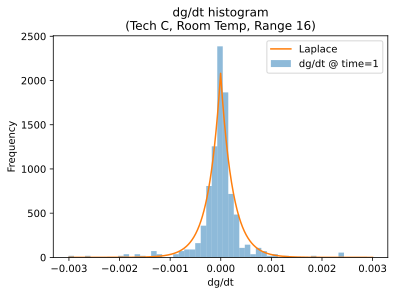

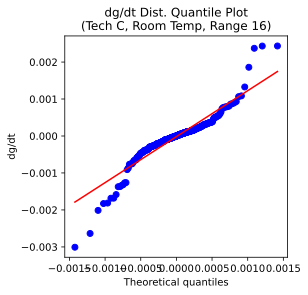

(254,)
nan
nan


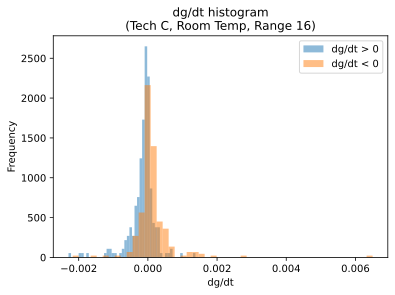

(488,)
nan
1.61455968828567e-07


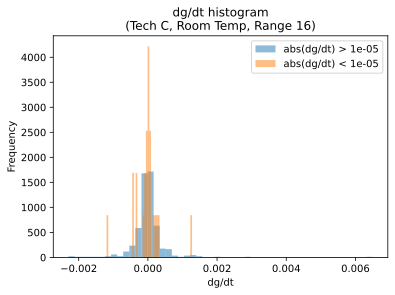

In [6]:
r = 16 # range
ti = 1 # initial conditioned time
tf = 2  # final conditioned time

def count_nearest(gvals):
    diff = gvals.drop_duplicates(subset=['time']).sort_values(["time"]).diff()[1:]
    gvals = gvals[1:]
    gvals["deriv"] = diff["g"].div(diff["time"])
    idx_i = gvals["time"].sub(ti).abs().idxmin()
    idx_f = gvals["time"].sub(tf).abs().idxmin()
    print(gvals.loc[[idx_i+20]])
    print(gvals.loc[[idx_i-20]])
    deriv_i = gvals.loc[idx_i]["deriv"].mean()
    deriv_f = gvals.loc[idx_i+1]["deriv"].mean()
    return [deriv_i, deriv_f]

# deriv_i is dg/dt at time ti, deriv_f is dg/dt at time tf
cnt = data[data["range"]==r].groupby("addr")[["g", "time"]].apply(count_nearest)
cnt = np.array([np.array(xi) for xi in cnt])
deriv_i = cnt[:, 0]
deriv_f = cnt[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(deriv_i, density=True, bins=50, alpha = 0.5, label=f"dg/dt @ time={ti}")

lnspc = np.linspace(-3e-3, 3e-3, 1000)
ag, bg = scipy.stats.laplace.fit(deriv_i)  
pdf_laplace = scipy.stats.laplace.pdf(lnspc, ag, bg)
plt.plot(lnspc, pdf_laplace, label="Laplace")
np.savetxt("test.csv", deriv_i)
# ax.hist(deriv_f, density=True, bins=50, alpha = 0.5, label=f"dg/dt @ time={tf}")

ax.set_title(f"dg/dt histogram\n(Tech {TECH}, Room Temp, Range 16)")
ax.legend()
ax.set_ylabel("Frequency")
ax.set_xlabel("dg/dt")
plt.savefig("deriv-time.png", bbox_inches="tight")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
scipy.stats.probplot(deriv_i, dist='laplace', sparams=(ag, bg), plot=ax, fit=True)
ax.set_title(f"dg/dt Dist. Quantile Plot\n(Tech {TECH}, Room Temp, Range {r})")
ax.set_ylabel("dg/dt")
plt.savefig(f"deriv-quantile.png", bbox_inches="tight")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

print(deriv_f[deriv_i > 0].shape)
print(np.mean(deriv_f[deriv_i > 0]))
print(np.mean(deriv_f[deriv_i < 0]))

ax.hist(deriv_f[deriv_i > 0], density=True, bins=50, alpha = 0.5, label="dg/dt > 0")
ax.hist(deriv_f[deriv_i < 0], density=True, bins=50, alpha = 0.5, label="dg/dt < 0")

ax.set_title(f"dg/dt histogram\n(Tech {TECH}, Room Temp, Range 16)")
ax.legend()
ax.set_ylabel("Frequency")
ax.set_xlabel("dg/dt")
plt.savefig("deriv-posneg.png", bbox_inches="tight")
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

th = 1e-5
print(deriv_f[abs(deriv_i) > th].shape)
print(np.var(deriv_f[abs(deriv_i) > th]))
print(np.var(deriv_f[abs(deriv_i) < th]))
ax.hist(deriv_f[abs(deriv_i) > th], density=True, bins=50, alpha = 0.5, label=f"abs(dg/dt) > {th}")
ax.hist(deriv_f[abs(deriv_i) < th], density=True, bins=50, alpha = 0.5, label=f"abs(dg/dt) < {th}")

ax.set_title(f"dg/dt histogram\n(Tech {TECH}, Room Temp, Range 16)")
ax.legend()
ax.set_ylabel("Frequency")
ax.set_xlabel("dg/dt")
plt.savefig("deriv-abs.png", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.


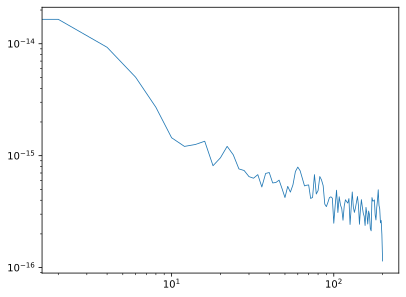

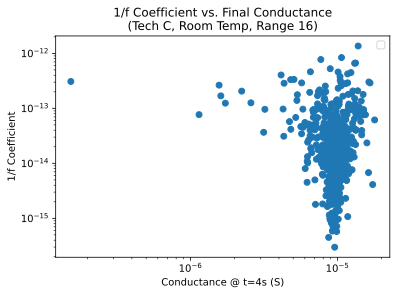

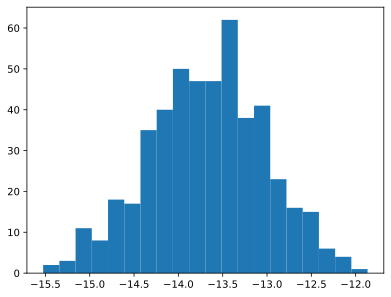

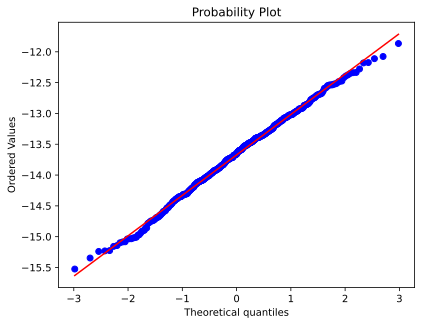

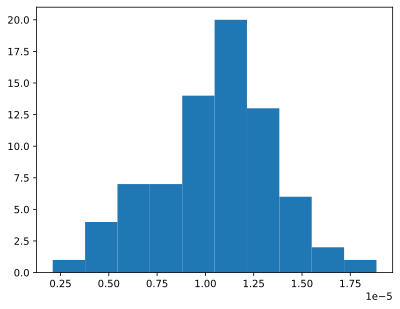

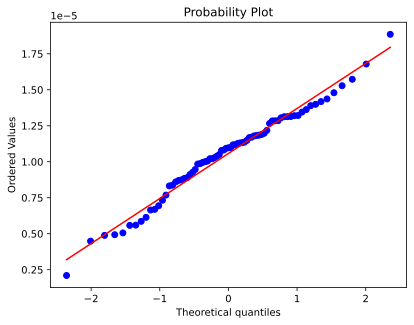

No handles with labels found to put in legend.


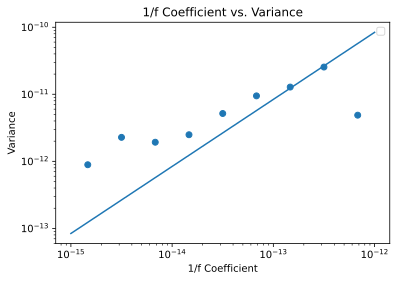

In [7]:
r = 8 # range
ti = 1 # initial conditioned time
tf = 2  # final conditioned time

f = lambda x, *p: p[0] / x

def noise_fit(gvals):
    gvals = gvals.drop_duplicates(subset=['time']).sort_values(["time"])
    freq, p = scipy.signal.welch(gvals["g"], fs=settings["fs"], nperseg=200)
    if noise_fit.counter == 0:
        noise_fit.counter += 1
        plt.loglog(freq, p, label=r, linewidth=0.8)
    popt, pcov = scipy.optimize.curve_fit(f, freq[1:], p[1:], [1])
    return [gvals["g"].values[-1], popt[0]]

noise_fit.counter = 0

# deriv_i is dg/dt at time ti, deriv_f is dg/dt at time tf
cnt = data[(data["range"]==r) & (data["time"] < 10)].groupby("addr")[["g", "time"]].apply(noise_fit)
cnt = np.array([np.array(xi) for xi in cnt])
gf = cnt[:, 0]
popt = cnt[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(abs(gf-2e-5), popt)
ax.set_title(f"1/f Coefficient vs. Final Conductance\n(Tech {TECH}, Room Temp, Range 16)")
ax.legend()
ax.set_ylabel("1/f Coefficient")
ax.set_xlabel("Conductance @ t=4s (S)")
ax.set_xscale("log")
ax.set_yscale("log")
# plt.plot([1e-6, 1e-5], [1e-15, 1e-13], '-r')
plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()

plt.hist(np.log10(popt), bins=20)
plt.show()

scipy.stats.probplot(np.log10(popt), dist='norm', plot=plt, fit=True)
plt.show()

N = 10
x1 = np.logspace(-15, -12, N, endpoint=True)
popt_var = np.zeros(N-1)
for i in range(N-1):
    if i == 5:
        plt.hist(gf[(popt < x1[i+1]) & (popt > x1[i])])
        plt.show()
        scipy.stats.probplot(gf[(popt < x1[i+1]) & (popt > x1[i])], dist='norm', plot=plt, fit=True)
        plt.show()
    popt_var[i] = np.var(gf[(popt < x1[i+1]) & (popt > x1[i])])
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(np.sqrt(x1[:-1] * x1[1:]), popt_var)
ax.plot(x1, x1 * np.log(800) * 4 * np.pi)
ax.set_title(f"1/f Coefficient vs. Variance")
ax.legend()
ax.set_xlabel("1/f Coefficient")
ax.set_ylabel("Variance")
ax.set_xscale("log")
ax.set_yscale("log")
# plt.plot([1e-6, 1e-5], [1e-15, 1e-13], '-r')
plt.savefig("var.png", bbox_inches="tight")
plt.show()

In [8]:
k = 4 * np.pi * np.log(800)

sigma = np.std(np.log(popt))
mu = np.mean(np.log(popt))

g_sample = np.linspace(1e-5, 3e-5, 100)
print(sigma)
print(mu)

1.5051231411864086
-31.483675677925262


C:\Users\mxy\Anaconda3\envs\py39\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 200 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
No handles with labels found to put in legend.


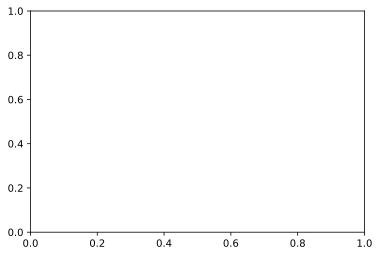

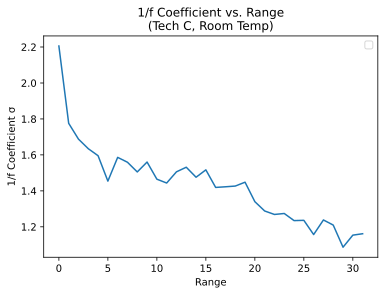

No handles with labels found to put in legend.


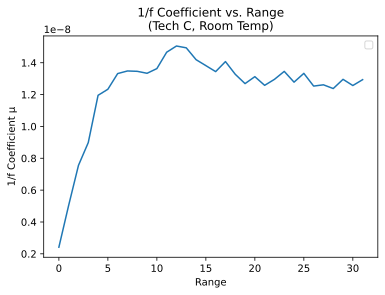

In [10]:
# r = 16 # range
# ti = 1 # initial conditioned time
# tf = 2  # final conditioned time

f = lambda x, *p: p[0] / x

def noise_fit(gvals):
    gvals = gvals.drop_duplicates(subset=['time']).sort_values(["time"])
    freq, p = scipy.signal.welch(gvals["g"], fs=settings["fs"], nperseg=200)
    popt, pcov = scipy.optimize.curve_fit(f, freq[1:], p[1:], [1])
    return [gvals["g"].values[-1], popt[0], gvals["g"].values[0]]

sigma = np.zeros(32)
mu = np.zeros(32)
mean_drift_1 = np.zeros(32)
mean_drift_2 = np.zeros(32)
mean_drift_3 = np.zeros(32)
mean_drift_4 = np.zeros(32)

for r in range(32):
    # deriv_i is dg/dt at time ti, deriv_f is dg/dt at time tf
    cnt = data[(data["range"]==r) & (data["time"] < 10)].groupby("addr")[["g", "time"]].apply(noise_fit)
    cnt = np.array([np.array(xi) for xi in cnt])
    gf = cnt[:, 0]
    popt = cnt[:, 1]
    gi = cnt[:, 2]

    sigma[r] = np.std(np.log(popt))
    mu[r] = np.mean(np.log(popt))
    mean_drift_x = (gf - gi) / np.sqrt(popt)
    # mean_drift[r] = mean_drift_x.mean()
    mean_drift_1[r] = mean_drift_x[popt > np.exp(mu[r] + 1)].mean()
    mean_drift_2[r] = mean_drift_x[(popt > np.exp(mu[r])) & (popt < np.exp(mu[r] + 1))].mean()
    mean_drift_3[r] = mean_drift_x[(popt < np.exp(mu[r])) & (popt > np.exp(mu[r] - 1))].mean()
    mean_drift_4[r] = mean_drift_x[popt < np.exp(mu[r] - 1)].mean()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(32), sigma)
ax.set_title(f"1/f Coefficient vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("1/f Coefficient σ")
ax.set_xlabel("Range")
plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(32), 10**(mu/4))
ax.set_title(f"1/f Coefficient vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("1/f Coefficient μ")
ax.set_xlabel("Range")
plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()


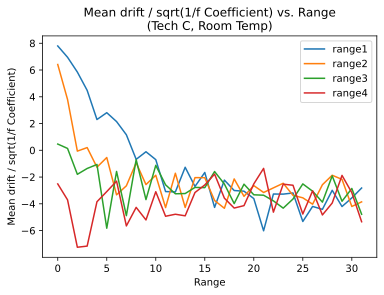

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(32), mean_drift_1, label='range1')
ax.plot(range(32), mean_drift_2, label='range2')
ax.plot(range(32), mean_drift_3, label='range3')
ax.plot(range(32), mean_drift_4, label='range4')
ax.set_title(f"Mean drift / sqrt(1/f Coefficient) vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("Mean drift / sqrt(1/f Coefficient)")
ax.set_xlabel("Range")
# plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()

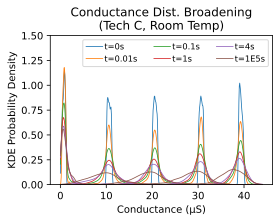

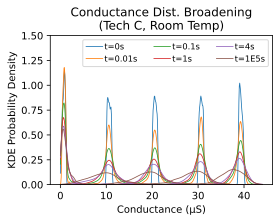

In [13]:
colnames = ["addr", "time", "r", "g", "gi", "range", "timept"]
data1 = pd.read_csv(f"data/tech{TECH}/relaxdata.min.tsv.gz", names=colnames, sep='\t')
data1.head()

# Select ranges to study
ranges = [0, 8, 16, 24, 31]

# Conductance broadening behavior
fig = plt.figure(figsize=(4, 2.7))
ax = fig.add_subplot(111)
ax.set_title(f"Conductance Dist. Broadening\n(Tech {TECH}, Room Temp)")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for time, color in zip(settings["times"], colors):
    for r in ranges:
        gx = np.linspace(0, settings["gmax"] * 1.1e6, 500)
        gvals = data1[(data1["range"] == r) & (data1["timept"] == time)]["g"]
        pdf = scipy.stats.gaussian_kde(gvals * 1e6).pdf(gx)
        label = (f"t={time}s" if time < 100 else f"t=1E{int(np.log10(time))}s") if r == 0 else None
        plt.plot(gx, pdf, color=color, label=label, linewidth=0.8)
ax.legend(ncol=3, handletextpad=0.2, fontsize="small")
ax.set_ylim(*settings["gbroad_ylim"])
ax.set_xlabel("Conductance (µS)")
ax.set_ylabel("KDE Probability Density")
plt.show()

-3.6655827693206655
0
8
16
24
31


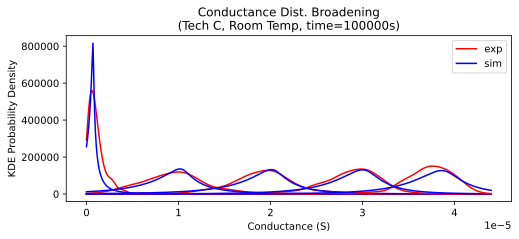

No handles with labels found to put in legend.


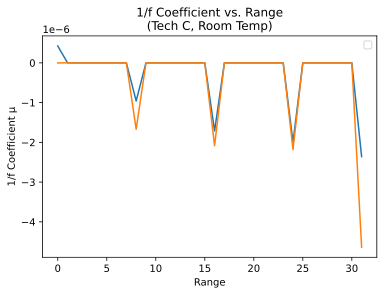

In [15]:
# ranges = np.arange(32)
ranges = [0, 8, 16, 24, 31]

tf = 100000

gx = np.linspace(0, settings["gmax"] * 1.1, 500)

def f(x, sigma, mu, mean_drift, k, g0, g):
    return np.exp(-(np.log(x) - mu) ** 2 / (2 * sigma * sigma)) * np.exp(-(g-g0-mean_drift*np.sqrt(x)) ** 2 / (2 * k * x)) / np.sqrt(2 * np.pi * k * x) / (x * sigma * np.sqrt(2 * np.pi))
# print(integrate.quad(f, 0, 1e-11, args=(sigma[16], mu[16], 4 * np.pi * np.log(400 * tf / 2), 2.06e-5, 2.06e-5))[0])

md_real = np.zeros(32)
md_sim = np.zeros(32)

# mx = np.mean(mean_drift[6:] + mean_drift_new[6:]) / 2
mx = np.mean(mean_drift_4[6:])
# mx = -1.7e7
print(mx)
mx = -4.5

fig, ax = plt.subplots(figsize=(8, 3))
g = gx
for r in ranges:
    print(r)
# g = np.linspace(1e-5, 3e-5, 1000)
# res = [np.sum([integrate.quad(f, 0, 1e-11, args=(sigma[16], mu[16], 4 * np.pi * np.log(20), j, i))[0] * (1.1 * 40e-6 / 500) for j in gx] * pdf) for i in g]
    gvals = data1[(data1["range"] == r) & (data1["timept"] == 0)]["g"]
    pdf = scipy.stats.gaussian_kde(gvals).pdf(gx)
    mean = np.mean(gvals)
    res = [integrate.quad(f, 0, 1e-11, args=(sigma[r], mu[r], mx / np.log(800) * np.log(400 * tf / 2), 4 * np.pi ** 2 * np.log(400 * tf / 2), mean, i))[0]for i in gx]
    # res = [np.sum([integrate.quad(f, 0, 1e-11, args=(sigma[r], mu[r], 8 * np.pi * np.log(400 * tf / 2), j, i))[0] * (1.1 * 40e-6 / 500) for j in gx] * pdf) for i in g]
    gvals_new = data1[(data1["range"] == r) & (data1["timept"] == tf)]["g"]
    pdf_new = scipy.stats.gaussian_kde(gvals_new).pdf(g)

    md_real[r] = np.sum((pdf_new - pdf) * gx) * (gx[1] - gx[0])
    md_sim[r] = np.sum((res - pdf) * gx) * (gx[1] - gx[0])


    ax.plot(gx, pdf_new, color='r', label= "exp" if r == 0 else None)
    ax.plot(gx, res, color='b', label= "sim" if r == 0 else None)
ax.legend()
ax.set_xlabel("Conductance (S)")
ax.set_ylabel("KDE Probability Density")
ax.set_title(f"Conductance Dist. Broadening\n(Tech {TECH}, Room Temp, time={tf}s)")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(32), md_real, range(32), md_sim)
ax.set_title(f"1/f Coefficient vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("1/f Coefficient μ")
ax.set_xlabel("Range")
# plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()

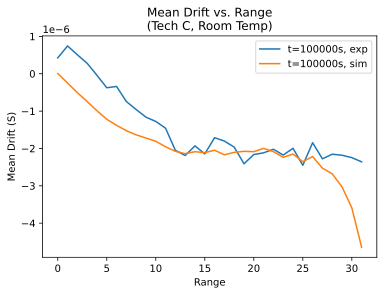

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(range(32), md_real_4, 'b', label='t=4s, exp')
# ax.plot(range(32), md_sim_4, 'bx', label='t=4s, sim')
ax.plot(range(32), md_real, label='t=100000s, exp')
ax.plot(range(32), md_sim, label='t=100000s, sim')
ax.set_title(f"Mean Drift vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("Mean Drift (S)")
ax.set_xlabel("Range")
plt.savefig("mean_pred.png", bbox_inches="tight")
plt.show()

No handles with labels found to put in legend.


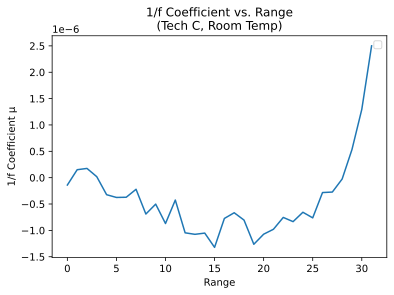

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(range(32), md_real - md_sim)
ax.set_title(f"1/f Coefficient vs. Range\n(Tech {TECH}, Room Temp)")
ax.legend()
ax.set_ylabel("1/f Coefficient μ")
ax.set_xlabel("Range")
# plt.savefig("oneoverf.png", bbox_inches="tight")
plt.show()

1.5538355986198481e-13
2.514916874219594


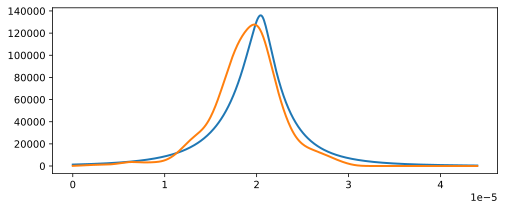

In [110]:
fig, ax = plt.subplots(figsize=(8, 3))
r = 16
tf = 100000
print(mean_drift_1[0] * np.exp(mu[16]) * np.log(400 * tf / 2) / np.log(800))
print(np.log(400 * tf / 2) / np.log(800))
gvals = data1[(data1["range"] == r) & (data1["timept"] == tf)]["g"]
pdf = scipy.stats.gaussian_kde(gvals).pdf(g)
mean = np.mean(data1[(data1["range"] == r) & (data1["timept"] == 0)]["g"])
res = [integrate.quad(f, 0, 1e-11, args=(sigma[r], mu[r], mean_drift_1[r] / np.log(800) * np.log(400 * tf / 2), 4 * np.pi ** 2 * np.log(400 * tf / 2), mean, i))[0]for i in gx]
# ax.plot(g, np.array(res) * (1.1 * 40e-6 / 500), g, pdf, lw=2)
ax.plot(g, res, g, pdf, lw=2)
plt.show()